In [1]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#from abtem.reconstruct import invms
from abtem.measure import Measurement, Calibration
from abtem.utils import energy2wavelength
from abtem.waves import Probe
from abtem.utils import energy2wavelength
import scipy.io as io


matplotlib.rcParams["figure.figsize"] = (20, 10)
matplotlib.rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
                'size'   : 22}
matplotlib.rc('font', **font)

In [2]:
data=io.loadmat("/home/jilek/Downloads/rawdata_1x_crop.mat") #data from https://data.paradim.org/blob/8a5b844f325841eba38156896d94d74de984cd6de4e9d52a553f0e8eac24c00c3da281f243e8e05352b62cea37536fbdf8efee60774aa925f85ce8df5d94b704
energy=data['voltage'][0,0]*1e3 # voltage in kV
#dp=data['cbed'].reshape((*data['cbed'].shape[:2],-1)) # from shape 124,124,60,60 to shape 124,124,3600 
dp=data['cbed'][:,:,30:30+30,0:0+30].reshape((*data['cbed'].shape[:2],-1)) # from shape 124,124,60,60 to shape 124,124,3600 (selecting only region of 30x30 scan points out of 60x60)
dp=dp.transpose((2,0,1)) # from shape 124,124,3600 to shape 3600,124,124
dp[dp<data['ADU']]=0
dp=dp/np.mean(np.sum(np.abs(dp),(1,2)))
N_dp=30 # see np.sqrt(np.shape(data['cbed'])[-1])
#N_dp=60 # see np.sqrt(np.shape(data['cbed'])[-1])
x = np.linspace(0,(N_dp-1)*data['scanstep'],N_dp) 
y = np.linspace(0,(N_dp-1)*data['scanstep'],N_dp) 
grid = np.meshgrid(x,y)
positions_x = grid[0].T.reshape(-1)
positions_y = grid[1].T.reshape(-1)

rot_angle = 30/180*np.pi
positions_x_rot = positions_x*np.cos(rot_angle) + positions_y*np.sin(rot_angle)  + 5
positions_y_rot = positions_x*-np.sin(rot_angle) + positions_y*np.cos(rot_angle) + 20
positions = np.array([positions_x_rot,positions_y_rot]).T

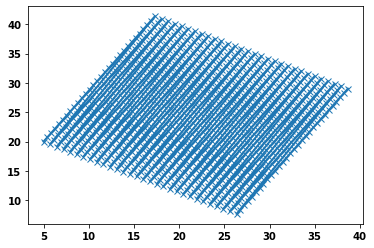

In [3]:
plt.figure()
plt.plot(positions_x_rot,positions_y_rot,"-x")
plt.show()

In [4]:
#scale_factor=1000*energy2wavelength(energy*1e3)#to convert spatial frequency to mrad
units = 'mrad'
names = ['alpha_x', 'alpha_y']

dk=data['alpha0']/1e3/data['rbf']/energy2wavelength(energy) #https://github.com/muller-group-cornell/ptychography/blob/73bf0b77560b5dcfaa03c11fbdd2c82f6f501395/get_inputs_real_new.m
dalpha=dk/(1/energy2wavelength(energy))*1e3

cals=(None,)
for name in names:
    cal=Calibration(offset=0,sampling=dalpha, units = units, name=names)
    cals+=(cal,)
measurement=Measurement(dp,calibrations=cals)

In [5]:
semiangle_cutoff = data['alpha0'][0,0]
defocus = data['df'][0,0]
#probe_guess = Probe(semiangle_cutoff=semiangle_cutoff, energy=energy,defocus=defocus,extent=40,gpts=256)
#reconstructions = invms(measurement, probe_guess, positions = positions, modes=3,k_modes=1, alpha=0.05, fac=1, beta=0.5, slices=1, slice_thickness=21,  maxiter=8, return_iterations=True, fix_com=True,device='gpu')

In [6]:
from reconstruct_g import MixedStatePtychographicOperator

mixed_states_ptycho_operator = MixedStatePtychographicOperator(
    measurement,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
    positions=positions,
    num_probes=1,
    device="gpu",
    parameters={"object_px_padding": (30, 30)},
).preprocess()

(
    mxrpie_objects,
    mxrpie_probes,
    mxrpie_positions,
    mxrpie_sse,
) = mixed_states_ptycho_operator.reconstruct(
    max_iterations=8*4,
    random_seed=1,
    return_iterations=True,
    verbose=True,
    parameters={"alpha":1, "beta":1, "object_step_size":0.03,"probe_step_size":0.3},
    warmup_update_steps=mixed_states_ptycho_operator._num_diffraction_patterns * 10,
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 9000 steps
--Mixed-State PIE for 19800 steps
--Probe correction is enabled


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

----Iteration 0 , SSE = 2.004e-06
----Iteration 1 , SSE = 1.977e-06
----Iteration 2 , SSE = 1.965e-06
----Iteration 3 , SSE = 1.956e-06
----Iteration 4 , SSE = 1.948e-06
----Iteration 5 , SSE = 1.941e-06
----Iteration 6 , SSE = 1.933e-06
----Iteration 7 , SSE = 1.926e-06
----Iteration 8 , SSE = 1.919e-06
----Iteration 9 , SSE = 1.912e-06
----Iteration 10, SSE = 1.905e-06
----Iteration 11, SSE = 1.899e-06
----Iteration 12, SSE = 1.892e-06
----Iteration 13, SSE = 1.886e-06
----Iteration 14, SSE = 1.881e-06
----Iteration 15, SSE = 1.876e-06
----Iteration 16, SSE = 1.871e-06
----Iteration 17, SSE = 1.866e-06
----Iteration 18, SSE = 1.863e-06
----Iteration 19, SSE = 1.859e-06
----Iteration 20, SSE = 1.855e-06
----Iteration 21, SSE = 1.853e-06
----Iteration 22, SSE = 1.849e-06
----Iteration 23, SSE = 1.847e-06
----Iteration 24, SSE = 1.844e-06
----Iteration 25, SSE = 1.840e-06
----Iteration 26, SSE = 1.839e-06
----Iteration 27, SSE = 1.838e-06
----Iteration 28, SSE = 1.838e-06
----Iteration 

In [7]:
mxrpie_objects[-1].angle().array.shape

(142, 142)

(-0.5, 123.5, -0.5, 123.5)

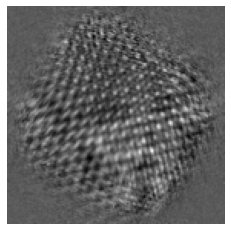

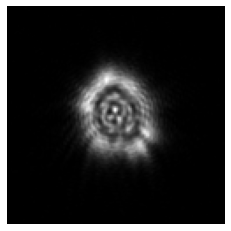

In [8]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.imshow(mxrpie_objects[-1].angle().array.T,origin="lower",cmap="gray")
plt.axis("off")
#plt.savefig("figs/abtem_object-probe_step_size0.03-object_step_size0.3.pdf")
plt.figure()
plt.imshow(mxrpie_probes[-1][0].intensity().array.T,origin="lower",cmap="gray")
plt.axis("off")
#plt.savefig("figs/abtem_probe-probe_step_size0.03object_step_size0.3.pdf")
#fig.tight_layout()

/home/jilek/py4DSTEM/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:648: UserWarning: Best fit rotation forced to 30 degrees.
  warnings.warn(
/home/jilek/py4DSTEM/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:662: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


Performing 32 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.3, in batches of max 256 measurements.


Reconstructing object and probe: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 18.51 iter/s]


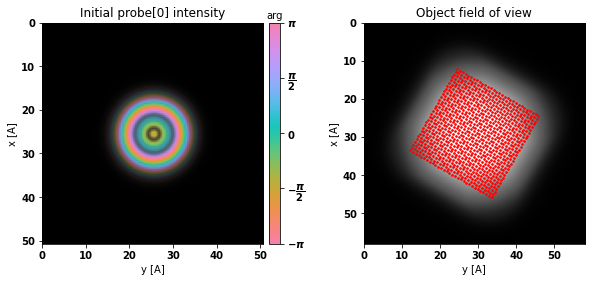

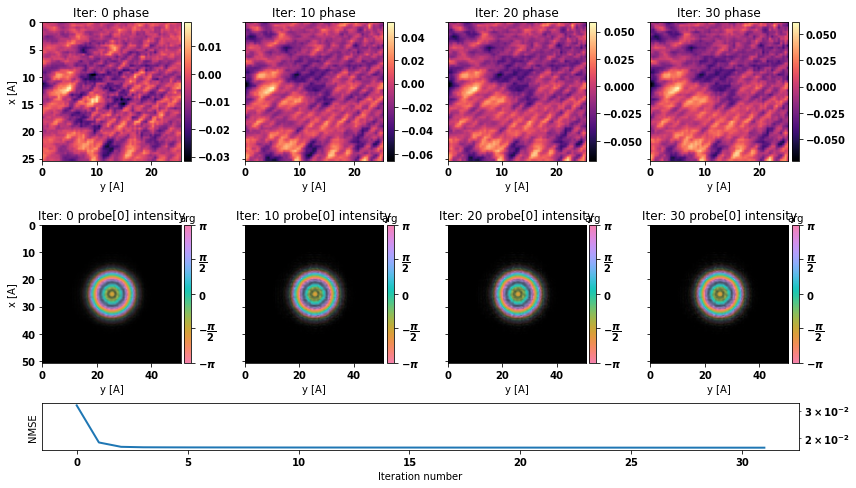

In [9]:
import py4DSTEM 
mee=measurement.array.reshape(N_dp,N_dp,124,124).transpose((0,1,2,3))
ca=py4DSTEM.data.calibration.Calibration()
ca["Q_pixel_size"]=np.squeeze(measurement.calibrations[1].sampling)
ca["R_pixel_size"]=np.linalg.norm(positions[1]-positions[0])
ca["Q_pixel_units"]="mrad"
ca["R_pixel_units"]="A"

dataset = py4DSTEM.DataCube(
    data=mee,
    calibration=ca
)


#ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
#ptycho = py4DSTEM.process.phase.MixedstateMultislicePtychographicReconstruction(
ptycho = py4DSTEM.process.phase.MixedstatePtychographicReconstruction(
    datacube=dataset,
    verbose=True,
    #initial_scan_positions=positions,
    energy=energy,
    #num_slices=2,
    #slice_thicknesses=10,
    num_probes=1,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
    C12=0,
    #C30=aberrations["C30"],
    device='gpu',
    object_padding_px=(30,30),
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
    force_com_rotation=30,
    force_com_transpose=False,
)

ptycho = ptycho.reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 32,
    tv_denoise_iter=0,
    butterworth_filter_iter=0,
    gaussian_filter_iter=0,
    fix_potential_baseline=True,    
    
    #normalization_min=1,
    #gaussian_filter_sigma=None,
    step_size=0.3, 
    #step_size_probe=1,
    max_batch_size=256
).visualize(
    iterations_grid = 'auto',
    #plot_fourier_probe=True,
    plot_probe=True
)

(-0.5, 141.5, -0.5, 141.5)

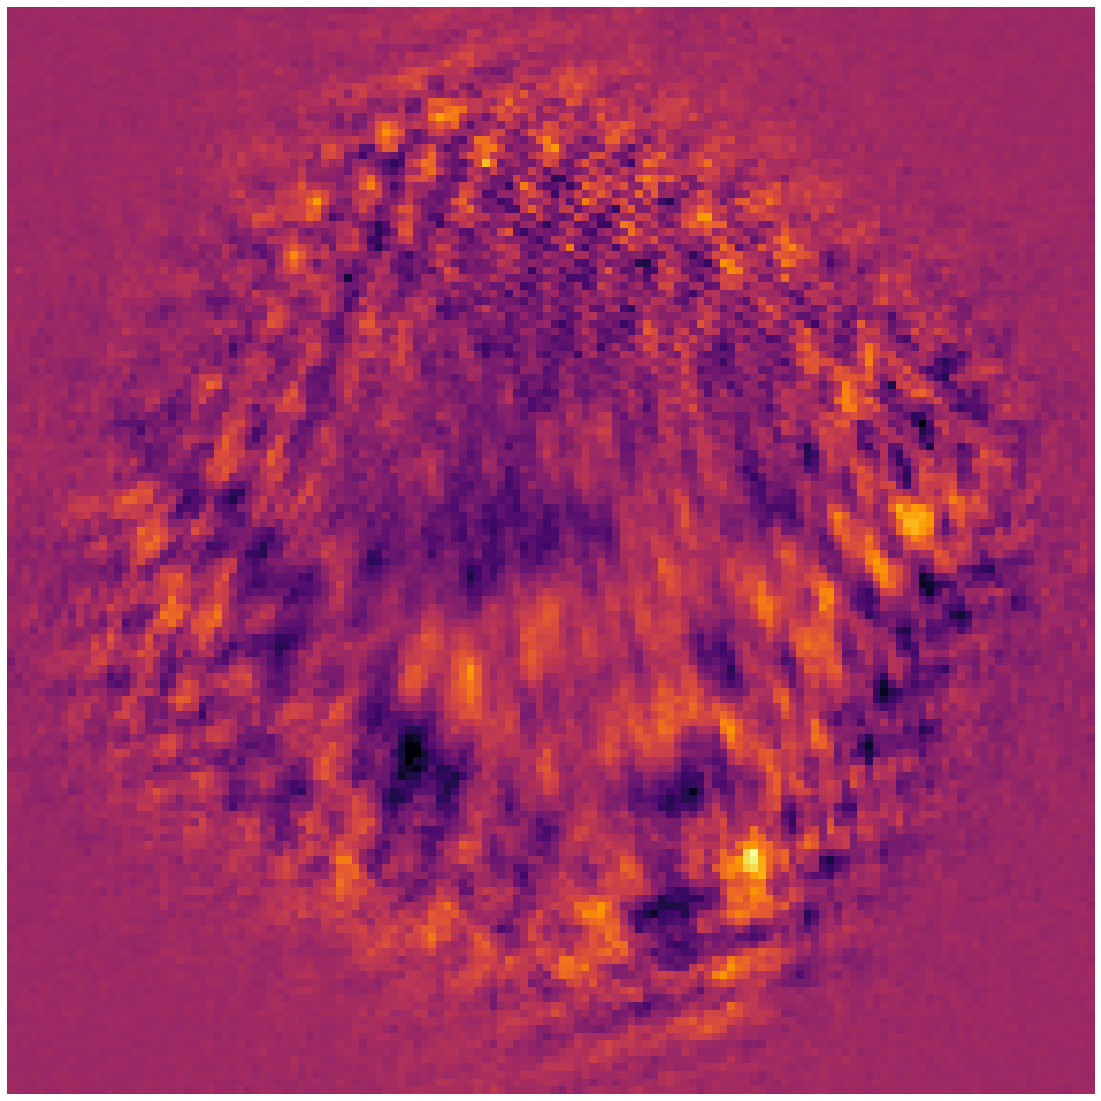

In [10]:
plt.figure(figsize=(20,20)) 
plt.imshow(np.angle(ptycho.object_iterations[-1]).T,cmap="inferno",origin='lower')
plt.axis("off")
#plt.savefig("figs/py4dstem_object-step_size0.3-batch_size1.pdf")

(-0.5, 123.5, 123.5, -0.5)

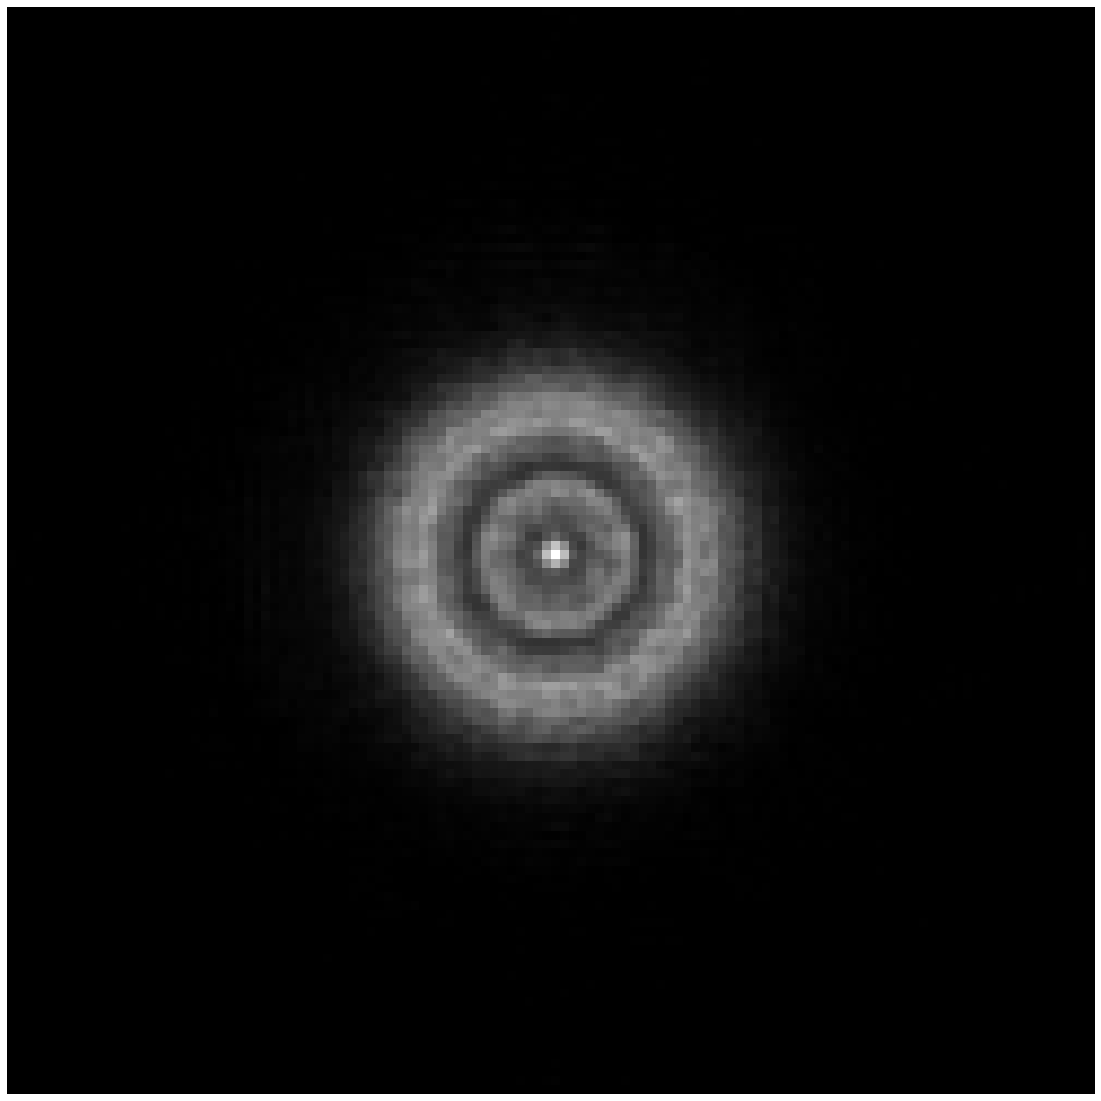

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(np.abs(ptycho.probe_iterations[-1][0])**2,cmap="gray")
plt.axis("off")
#plt.savefig("figs/py4dstem_probe-step_size0.3-batch_size1.pdf")